In [6]:
import numpy as np
import pandas as pd
from gym import spaces, Env
import tensorflow as tf
from tensorflow.keras import layers
import random
from collections import deque
from sklearn.preprocessing import StandardScaler
np.random.seed(0)
tf.random.set_seed(0)

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date', 'Stock'], inplace=True)
    
    # Use only 'Adj Close' prices and drop other columns
    df = df[['Adj Close']]
    
    # Ensure only valid 'Adj Close' prices are used
    stock_dfs = {stock: data.dropna() for stock, data in df.groupby(level='Stock')}
    
    return stock_dfs

def preprocess_benchmark_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df[['Adj Close']]  # Ensure only 'Adj Close' prices are used

# Load and preprocess data
train_data = preprocess_data('./data/stable_data_train_2014.csv')
test_data = preprocess_data('./data/stable_data_test_2015.csv')
benchmark_data = preprocess_benchmark_data('./data/benchmark_data_2015.csv')


# Stock Trading Environment 
class PortfolioTradingEnv(Env):
    def __init__(self, stock_data):
        super(PortfolioTradingEnv, self).__init__()
        self.stock_data = stock_data 
        self.stocks = list(stock_data.keys())
        self.num_stocks = len(self.stocks)
        self.state_size = self.num_stocks
        self.action_size = self.num_stocks

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_size,), dtype=np.float32) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_size,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 10000000
        self.holdings = {stock: 0 for stock in self.stocks}
        self.portfolio_value = self.balance
        return self._next_observation()

    def _next_observation(self): # Get the observation
        if self.current_step >= len(next(iter(self.stock_data.values()))): # Check if we have reached the end of the data
            self.current_step = len(next(iter(self.stock_data.values()))) - 1 # Reset the current step
        return np.array([self.stock_data[stock].iloc[self.current_step]['Adj Close'] for stock in self.stocks]) # Return the observation


    def step(self, actions):
        prev_portfolio_value = self.portfolio_value # Keep track of the portfolio value before taking actions
        self._take_actions(actions) # Take actions
        self.current_step += 1 # Move to the next time step

        done = self.current_step >= len(next(iter(self.stock_data.values()))) - 1 # Check if we have reached the end of the data
        self.portfolio_value = self.balance + sum(self.holdings[stock] * self.stock_data[stock].iloc[self.current_step]['Adj Close'] for stock in self.stocks) # Calculate the new portfolio value
        reward = self.portfolio_value - prev_portfolio_value # Calculate the reward
        obs = self._next_observation() # Get the new observation

        return obs, reward, done, {}

    def _take_actions(self, actions):
        actions = np.nan_to_num(actions)
        actions = np.clip(actions, -1, 1)
        for i, stock in enumerate(self.stocks):
            if actions[i] > 0:
                self._buy_stock(stock, actions[i])
            elif actions[i] < 0:
                self._sell_stock(stock, actions[i])
            else:
                self._hold_stock(stock)

    def _buy_stock(self, stock, action):
        # Ensure action is a positive value between 0 and 1
        #action = max(0, min(action, 1))

        # Calculate the amount of money to spend on the stock
        available_balance = self.balance
        stock_price = self.stock_data[stock].iloc[self.current_step]['Adj Close']
        
        # Calculate the amount of stock to buy based on the action
        amount_to_buy = (available_balance * action) / stock_price
        
        # Ensure the available balance is enough for the transaction
        if self.balance >= amount_to_buy * stock_price:
            self.balance -= amount_to_buy * stock_price
            self.holdings[stock] += amount_to_buy


    def _sell_stock(self, stock, action):
        # Ensure action is a negative value between -1 and 0
        #action = max(-1, min(action, 0))
        
        stock_price = self.stock_data[stock].iloc[self.current_step]['Adj Close']
        
        # Calculate the amount of stock to sell based on the action
        amount_to_sell = abs(action) * self.holdings[stock]
        
        # Ensure we have enough stock to sell
        if self.holdings[stock] >= amount_to_sell:
            self.holdings[stock] -= amount_to_sell
            self.balance += amount_to_sell * stock_price

    def _hold_stock(self, stock):
        #do nothing
        pass



# Initialize the environment for the portfolio
train_env = PortfolioTradingEnv(train_data) # Initialize the training environment
test_env = PortfolioTradingEnv(test_data)   # Initialize the testing environment

# DDPG Agent
class DDPG:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.actor_learning_rate = 0.0001  # Lower learning rate
        self.critic_learning_rate = 0.0002
        self.tau = 0.1  # Increase tau for smoother updates
        
        self.actor_model = self.build_actor()
        self.critic_model = self.build_critic()
        self.target_actor_model = self.build_actor()
        self.target_critic_model = self.build_critic()
        self.update_target_models()

    def build_actor(self):
        state_input = layers.Input(shape=(self.state_size,))
        h1 = layers.Dense(16, activation='relu')(state_input)
        h2 = layers.Dense(32, activation='relu')(h1)
        output = layers.Dense(self.action_size, activation='tanh')(h2)

        model = tf.keras.models.Model(inputs=state_input, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.actor_learning_rate))
        return model

    def build_critic(self):
        state_input = layers.Input(shape=(self.state_size,))
        state_h1 = layers.Dense(16, activation='relu')(state_input)
        state_h2 = layers.Dense(32, activation='relu')(state_h1)

        action_input = layers.Input(shape=(self.action_size,))
        action_h1 = layers.Dense(32, activation='relu')(action_input)

        merged = layers.Concatenate()([state_h2, action_h1])
        merged_h1 = layers.Dense(32, activation='relu')(merged)
        output = layers.Dense(1)(merged_h1)

        model = tf.keras.models.Model(inputs=[state_input, action_input], outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.critic_learning_rate), loss='mse')
        return model

    def update_target_models(self):
        actor_weights = self.actor_model.get_weights()
        actor_target_weights = self.target_actor_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * actor_target_weights[i]
        self.target_actor_model.set_weights(actor_target_weights)

        critic_weights = self.critic_model.get_weights()
        critic_target_weights = self.target_critic_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * critic_target_weights[i]
        self.target_critic_model.set_weights(critic_target_weights)

    @tf.function
    def train_critic(self, states, actions, target_qs):
        with tf.GradientTape() as tape:
            q_values = self.critic_model([states, actions], training=True)
            loss = tf.keras.losses.MeanSquaredError()(target_qs, q_values)
        critic_grads = tape.gradient(loss, self.critic_model.trainable_variables)
        clipped_grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in critic_grads]  # Gradient clipping
        self.critic_model.optimizer.apply_gradients(zip(clipped_grads, self.critic_model.trainable_variables))
        tf.print("Critic Loss:", loss)
        
    @tf.function
    def train_actor(self, states):
        with tf.GradientTape() as tape:
            actions_for_grad = self.actor_model(states, training=True)
            q_values = self.critic_model([states, actions_for_grad], training=True)
            actor_loss = -tf.reduce_mean(q_values)
        actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        clipped_grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in actor_grads]  # Gradient clipping
        self.actor_model.optimizer.apply_gradients(zip(clipped_grads, self.actor_model.trainable_variables))
        tf.print("Actor Loss:", actor_loss)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.reshape(state, [1, self.state_size])
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(-1, 1, self.action_size)
        action = np.nan_to_num(self.actor_model.predict(state)[0])
        action += np.random.normal(0, 0.1, size=action.shape)  # Adding Gaussian noise for exploration
        action = np.clip(action, -1, 1)
        return action

    def replay(self):
        if len(self.memory) < 32:  # Minibatch size reduced to 32
            return

        minibatch = random.sample(self.memory, 32)
        states = np.array([transition[0] for transition in minibatch], dtype=np.float32)
        actions = np.array([transition[1] for transition in minibatch], dtype=np.float32)
        rewards = np.array([transition[2] for transition in minibatch], dtype=np.float32)
        next_states = np.array([transition[3] for transition in minibatch], dtype=np.float32)
        dones = np.array([transition[4] for transition in minibatch], dtype=np.float32)

        target_actions = self.target_actor_model.predict(next_states)
        target_qs = rewards + self.gamma * np.squeeze(self.target_critic_model([next_states, target_actions])) * (1 - dones)
        target_qs = np.reshape(target_qs, (32, 1)).astype(np.float32)

        self.train_critic(states, actions, target_qs)
        self.train_actor(states)
        self.update_target_models()

def train_agent(env, agent, episodes):
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(len(env.stock_data[next(iter(env.stock_data))]) - 1):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
            agent.replay()
        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}")

# Train and Evaluate
state_size = train_env.state_size
action_size = train_env.action_size
agent = DDPG(state_size=state_size, action_size=action_size)

train_agent(train_env, agent, episodes=10)

       


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Critic Loss: 4.25490432e+09
Actor Loss: -103.89328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 4.281344e+09
Actor Loss: -109.975861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 4.33078784e+09
Actor Loss: -116.330612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 4.16651776e+09
Actor Loss: -122.455078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 2.18661837e+09
Actor Loss: -128.707489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 3.79268506e+09
Actor Loss: -134.545776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 3.19196262e+09
Actor Loss: -141.064972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Critic Loss: 6.86171136e+09
Actor Loss: -146.720215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 6.90721946e+09
Actor Loss: -152.74762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 7.1

Evaluating portfolio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Time: 0, Action: [ 1.  1. -1.], Reward: 7639.12, New Portfolio Value: 10007639.12, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Time: 1, Action: [ 1.  1. -1.], Reward: -207421.45, New Portfolio Value: 9800217.67, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 2, Action: [ 1.          0.94941235 -0.74547994], Reward: -19651.66, New Portfolio Value: 9780566.01, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 3, Action: [ 1.          1.         -0.96663254], Reward: 203058.34, New Portfolio Value: 9983624.35, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 4, Action: [ 0.98184174  1.         -1.        ], Reward: 31658.31, New Portfolio Value: 10015282.66, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 5, Action: [ 1.          0.744701   -0.93463814], Reward: 186683.43, New Portfolio Value: 10201966.09, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Tim

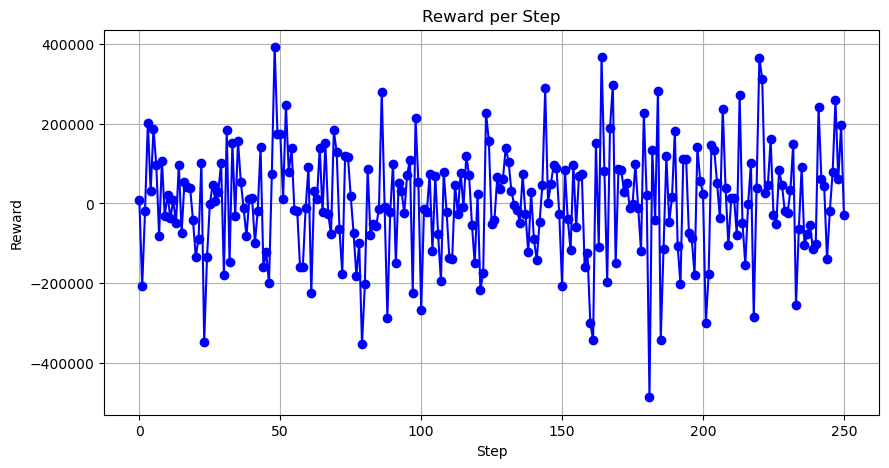

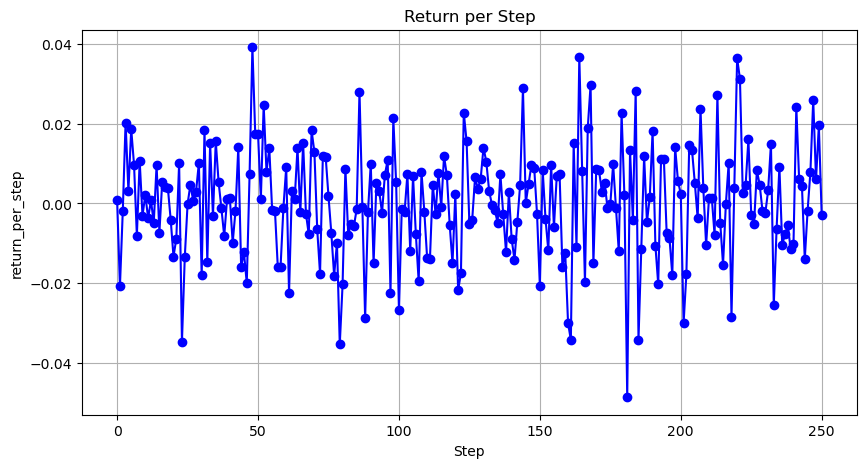

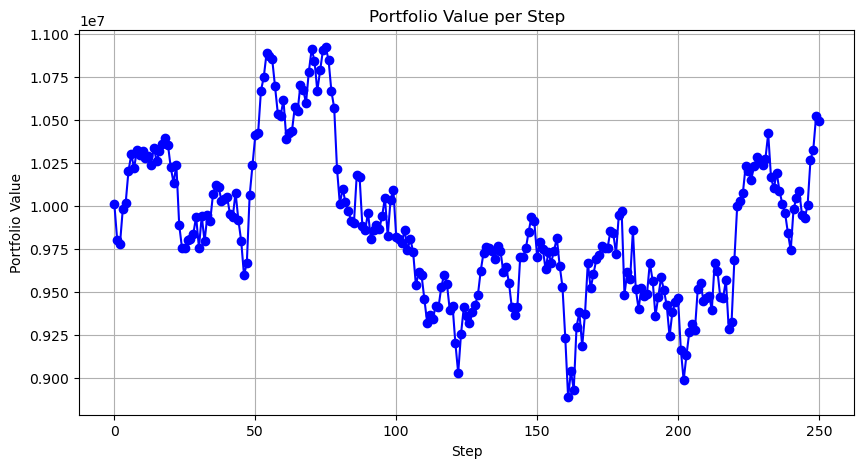

In [7]:

# Evaluate the agent with deterministic testing
def evaluate_agent(env, agent):
    np.random.seed(0)
    tf.random.set_seed(0)
    agent.epsilon = agent.epsilon_min  # Ensure the agent uses a deterministic policy

    portfolio_initial_value = 10000000
    state = env.reset()
    initial_value = portfolio_initial_value
    final_value = initial_value

    print("Evaluating portfolio")

    rewards = []
    prtf_value = []
    for time in range(len(next(iter(env.stock_data.values()))) - 1):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        final_value = env.portfolio_value
        rewards.append(reward)
        prtf_value.append(final_value)

        print(f"Time: {time}, Action: {action}, Reward: {reward:.2f}, New Portfolio Value: {final_value:.2f}, Cash Balance: {env.balance:.2f}")
        
        if done:
            break

    portfolio_return = (final_value - initial_value) / initial_value * 100
    return portfolio_return, rewards, prtf_value

portfolio_return, rewards, prtf_value = evaluate_agent(test_env, agent)
print(f"Portfolio Total Return: {portfolio_return:.2f}%")

# Calculate buy-and-hold return for the benchmark index
def calculate_benchmark_return(benchmark_data):
    initial_value = benchmark_data['Adj Close'].iloc[0]
    final_value = benchmark_data['Adj Close'].iloc[-1]
    buy_and_hold_return = (final_value - initial_value) / initial_value * 100
    return buy_and_hold_return

benchmark_return = calculate_benchmark_return(benchmark_data)
print(f"Benchmark Buy-and-Hold Return: {benchmark_return:.2f}%")

# Compare model's returns with the benchmark
def compare_with_benchmark(portfolio_return, benchmark_return):
    print(f"Model Portfolio Total Return: {portfolio_return:.2f}%")
    print(f"Benchmark Buy-and-Hold Return: {benchmark_return:.2f}%")

compare_with_benchmark(portfolio_return, benchmark_return)

if isinstance(rewards, list):
    return_per_step = [reward/10000000 for reward in rewards]
elif isinstance(rewards, (int, float)):
    return_per_step = rewards/10000000
else:
    print("rewards must be a number or a list/array of numbers")

import matplotlib.pyplot as plt
# Plotting the rewards per step
plt.figure(figsize=(10, 5))
plt.plot(range(len(rewards)), rewards, marker='o', linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
# Plotting the rewards per step
plt.figure(figsize=(10, 5))
plt.plot(range(len(return_per_step)), return_per_step, marker='o', linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('return_per_step')
plt.title('Return per Step')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
# Plotting the portfolio value per step
plt.figure(figsize=(10, 5))
plt.plot(range(len(prtf_value)), prtf_value, marker='o', linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value per Step')
plt.grid(True)
plt.show()

In [2]:
import numpy as np
import pandas as pd
from gym import spaces, Env
import tensorflow as tf
from tensorflow.keras import layers
import random
from collections import deque
from sklearn.preprocessing import StandardScaler
np.random.seed(0)
tf.random.set_seed(0)

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date', 'Stock'], inplace=True)
    
    # Use only 'Adj Close' prices and drop other columns
    df = df[['Adj Close']]
    
    # Ensure only valid 'Adj Close' prices are used
    stock_dfs = {stock: data.dropna() for stock, data in df.groupby(level='Stock')}
    
    return stock_dfs

def preprocess_benchmark_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df[['Adj Close']]  # Ensure only 'Adj Close' prices are used


# Load and preprocess data
train_data = preprocess_data('./data/combined_crisis_data_train_2008_2009.csv')
test_data = preprocess_data('./data/combined_test_data_2010.csv')
benchmark_data = preprocess_benchmark_data('./data/benchmark_data_2010.csv')

# Stock Trading Environment 
class PortfolioTradingEnv(Env):
    def __init__(self, stock_data):
        super(PortfolioTradingEnv, self).__init__()
        self.stock_data = stock_data 
        self.stocks = list(stock_data.keys())
        self.num_stocks = len(self.stocks)
        self.state_size = self.num_stocks
        self.action_size = self.num_stocks

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_size,), dtype=np.float32) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_size,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 10000000
        self.holdings = {stock: 0 for stock in self.stocks}
        self.portfolio_value = self.balance
        return self._next_observation()

    def _next_observation(self): # Get the observation
        if self.current_step >= len(next(iter(self.stock_data.values()))): # Check if we have reached the end of the data
            self.current_step = len(next(iter(self.stock_data.values()))) - 1 # Reset the current step
        return np.array([self.stock_data[stock].iloc[self.current_step]['Adj Close'] for stock in self.stocks]) # Return the observation


    def step(self, actions):
        prev_portfolio_value = self.portfolio_value # Keep track of the portfolio value before taking actions
        self._take_actions(actions) # Take actions
        self.current_step += 1 # Move to the next time step

        done = self.current_step >= len(next(iter(self.stock_data.values()))) - 1 # Check if we have reached the end of the data
        self.portfolio_value = self.balance + sum(self.holdings[stock] * self.stock_data[stock].iloc[self.current_step]['Adj Close'] for stock in self.stocks) # Calculate the new portfolio value
        reward = self.portfolio_value - prev_portfolio_value # Calculate the reward
        obs = self._next_observation() # Get the new observation

        return obs, reward, done, {}

    def _take_actions(self, actions):
        actions = np.nan_to_num(actions)
        actions = np.clip(actions, -1, 1)
        for i, stock in enumerate(self.stocks):
            if actions[i] > 0:
                self._buy_stock(stock, actions[i])
            elif actions[i] < 0:
                self._sell_stock(stock, actions[i])
            else:
                self._hold_stock(stock)

    def _buy_stock(self, stock, action):
        # Ensure action is a positive value between 0 and 1
        #action = max(0, min(action, 1))

        # Calculate the amount of money to spend on the stock
        available_balance = self.balance
        stock_price = self.stock_data[stock].iloc[self.current_step]['Adj Close']
        
        # Calculate the amount of stock to buy based on the action
        amount_to_buy = (available_balance * action) / stock_price
        
        # Ensure the available balance is enough for the transaction
        if self.balance >= amount_to_buy * stock_price:
            self.balance -= amount_to_buy * stock_price
            self.holdings[stock] += amount_to_buy


    def _sell_stock(self, stock, action):
        # Ensure action is a negative value between -1 and 0
        #action = max(-1, min(action, 0))
        
        stock_price = self.stock_data[stock].iloc[self.current_step]['Adj Close']
        
        # Calculate the amount of stock to sell based on the action
        amount_to_sell = abs(action) * self.holdings[stock]
        
        # Ensure we have enough stock to sell
        if self.holdings[stock] >= amount_to_sell:
            self.holdings[stock] -= amount_to_sell
            self.balance += amount_to_sell * stock_price

    def _hold_stock(self, stock):
        #do nothing
        pass


# Initialize the environment for the portfolio
train_env = PortfolioTradingEnv(train_data) # Initialize the training environment
test_env = PortfolioTradingEnv(test_data)   # Initialize the testing environment

# DDPG Agent
class DDPG:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.actor_learning_rate = 0.0001  # Lower learning rate
        self.critic_learning_rate = 0.0002
        self.tau = 0.1  # Increase tau for smoother updates
        
        self.actor_model = self.build_actor()
        self.critic_model = self.build_critic()
        self.target_actor_model = self.build_actor()
        self.target_critic_model = self.build_critic()
        self.update_target_models()

    def build_actor(self):
        state_input = layers.Input(shape=(self.state_size,))
        h1 = layers.Dense(16, activation='relu')(state_input)
        h2 = layers.Dense(32, activation='relu')(h1)
        output = layers.Dense(self.action_size, activation='tanh')(h2)

        model = tf.keras.models.Model(inputs=state_input, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.actor_learning_rate))
        return model

    def build_critic(self):
        state_input = layers.Input(shape=(self.state_size,))
        state_h1 = layers.Dense(16, activation='relu')(state_input)
        state_h2 = layers.Dense(32, activation='relu')(state_h1)

        action_input = layers.Input(shape=(self.action_size,))
        action_h1 = layers.Dense(32, activation='relu')(action_input)

        merged = layers.Concatenate()([state_h2, action_h1])
        merged_h1 = layers.Dense(32, activation='relu')(merged)
        output = layers.Dense(1)(merged_h1)

        model = tf.keras.models.Model(inputs=[state_input, action_input], outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.critic_learning_rate), loss='mse')
        return model

    def update_target_models(self):
        actor_weights = self.actor_model.get_weights()
        actor_target_weights = self.target_actor_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * actor_target_weights[i]
        self.target_actor_model.set_weights(actor_target_weights)

        critic_weights = self.critic_model.get_weights()
        critic_target_weights = self.target_critic_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * critic_target_weights[i]
        self.target_critic_model.set_weights(critic_target_weights)

    @tf.function
    def train_critic(self, states, actions, target_qs):
        with tf.GradientTape() as tape:
            q_values = self.critic_model([states, actions], training=True)
            loss = tf.keras.losses.MeanSquaredError()(target_qs, q_values)
        critic_grads = tape.gradient(loss, self.critic_model.trainable_variables)
        clipped_grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in critic_grads]  # Gradient clipping
        self.critic_model.optimizer.apply_gradients(zip(clipped_grads, self.critic_model.trainable_variables))
        tf.print("Critic Loss:", loss)
        
    @tf.function
    def train_actor(self, states):
        with tf.GradientTape() as tape:
            actions_for_grad = self.actor_model(states, training=True)
            q_values = self.critic_model([states, actions_for_grad], training=True)
            actor_loss = -tf.reduce_mean(q_values)
        actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        clipped_grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in actor_grads]  # Gradient clipping
        self.actor_model.optimizer.apply_gradients(zip(clipped_grads, self.actor_model.trainable_variables))
        tf.print("Actor Loss:", actor_loss)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.reshape(state, [1, self.state_size])
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(-1, 1, self.action_size)
        action = np.nan_to_num(self.actor_model.predict(state)[0])
        action += np.random.normal(0, 0.1, size=action.shape)  # Adding Gaussian noise for exploration
        action = np.clip(action, -1, 1)
        return action

    def replay(self):
        if len(self.memory) < 32:  # Minibatch size reduced to 32
            return

        minibatch = random.sample(self.memory, 32)
        states = np.array([transition[0] for transition in minibatch], dtype=np.float32)
        actions = np.array([transition[1] for transition in minibatch], dtype=np.float32)
        rewards = np.array([transition[2] for transition in minibatch], dtype=np.float32)
        next_states = np.array([transition[3] for transition in minibatch], dtype=np.float32)
        dones = np.array([transition[4] for transition in minibatch], dtype=np.float32)

        target_actions = self.target_actor_model.predict(next_states)
        target_qs = rewards + self.gamma * np.squeeze(self.target_critic_model([next_states, target_actions])) * (1 - dones)
        target_qs = np.reshape(target_qs, (32, 1)).astype(np.float32)

        self.train_critic(states, actions, target_qs)
        self.train_actor(states)
        self.update_target_models()

def train_agent(env, agent, episodes):
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(len(env.stock_data[next(iter(env.stock_data))]) - 1):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
            agent.replay()
        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}")

# Train and Evaluate
state_size = train_env.state_size
action_size = train_env.action_size
agent = DDPG(state_size=state_size, action_size=action_size)

train_agent(train_env, agent, episodes=10)

       


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Critic Loss: 3.37427169e+10
Actor Loss: 11.3385105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 3.37417748e+10
Actor Loss: 15.6770582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 3.32487844e+10
Actor Loss: 19.9922295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 3.36282501e+10
Actor Loss: 24.2984886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 3.19095235e+10
Actor Loss: 28.5372772
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Critic Loss: 2.71312e+10
Actor Loss: 32.9471893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Critic Loss: 3.05531126e+10
Actor Loss: 37.3596497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Critic Loss: 3.0116991e+10
Actor Loss: 41.664711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Critic Loss: 2.70069187e+10
Actor Loss: 45.479744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Critic Loss: 3.1945302e+10


Evaluating portfolio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 0, Action: [ 0.9034736 -1.        -0.8306351], Reward: -102914.63, New Portfolio Value: 9897085.37, Cash Balance: 965263.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Time: 1, Action: [ 0.93447113 -0.96418035 -1.        ], Reward: -109917.76, New Portfolio Value: 9787167.60, Cash Balance: 63252.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 2, Action: [ 0.94062525 -1.         -0.9469975 ], Reward: 120801.71, New Portfolio Value: 9907969.31, Cash Balance: 3755.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 3, Action: [ 1.         -0.93862754 -1.        ], Reward: -6809.18, New Portfolio Value: 9901160.13, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 4, Action: [ 0.9221994 -0.9156778 -1.       ], Reward: 158297.24, New Portfolio Value: 10059457.37, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Time: 5, Action: [ 0.82551193 -0.9382039  -0.87953585], Reward: -90215.98, New Portfolio Value: 9969241.40, Cash B

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Time: 168, Action: [ 0.8850404 -1.        -0.972025 ], Reward: 108704.83, New Portfolio Value: 11802710.98, Cash Balance: 3945.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Time: 169, Action: [ 0.9077867 -1.        -1.       ], Reward: 105169.56, New Portfolio Value: 11907880.54, Cash Balance: 363.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Time: 170, Action: [ 0.91624093 -1.         -0.95936817], Reward: -1779.33, New Portfolio Value: 11906101.22, Cash Balance: 30.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Time: 171, Action: [ 1. -1. -1.], Reward: -21393.86, New Portfolio Value: 11884707.35, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Time: 172, Action: [ 0.99898165 -1.         -0.9904862 ], Reward: 5344.73, New Portfolio Value: 11890052.08, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Time: 173, Action: [ 1.         -0.892175   -0.99230325], Reward: 158655.18, New Portfolio Value: 12048707.26, Cash Balance: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━

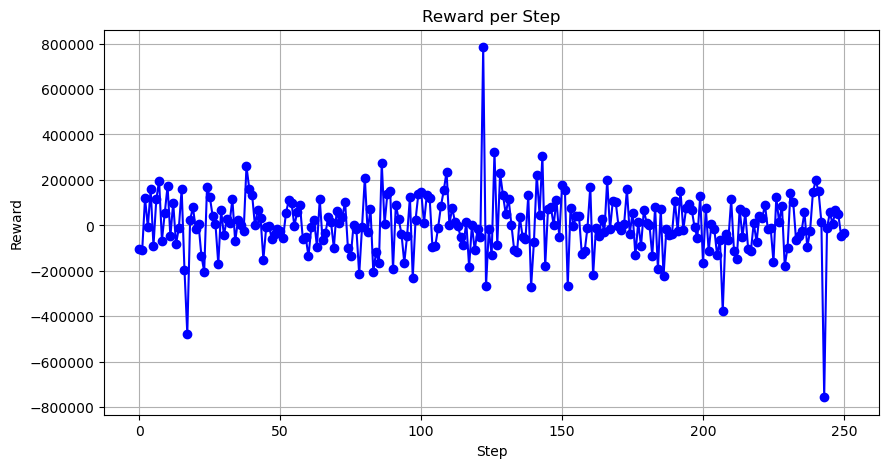

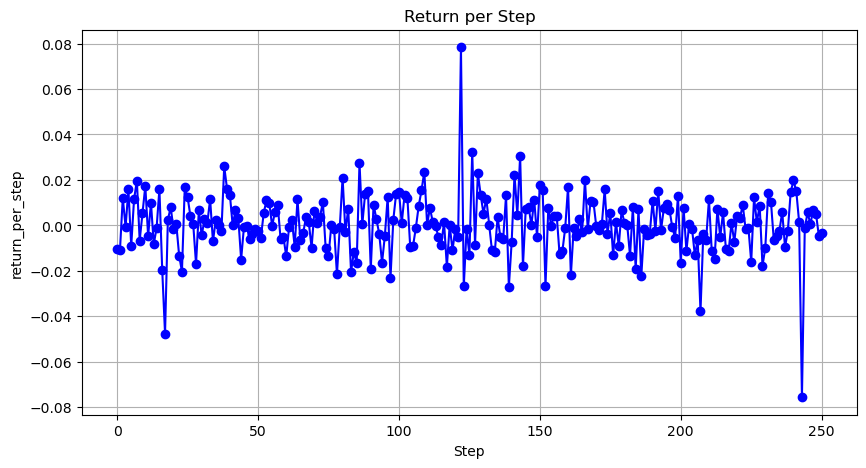

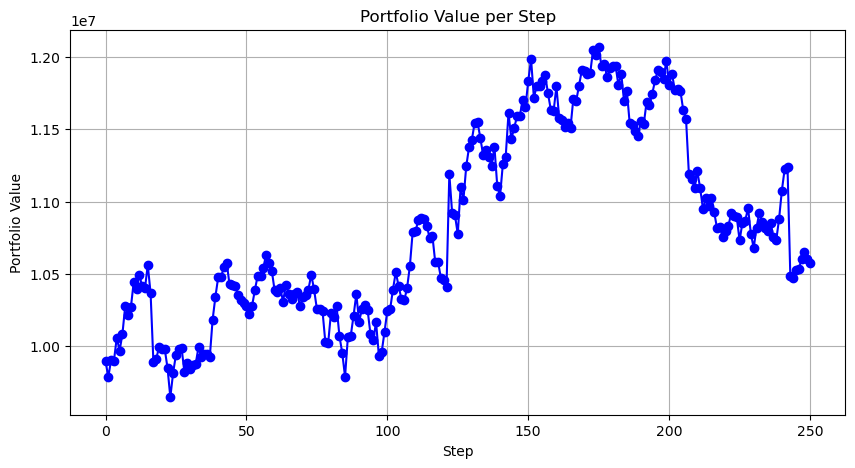

In [22]:

# Evaluate the agent
def evaluate_agent(env, agent):
    portfolio_initial_value = 10000000
    state = env.reset()
    initial_value = portfolio_initial_value
    final_value = initial_value

    print("Evaluating portfolio")

    rewards = []
    prtf_value = []
    for time in range(len(next(iter(env.stock_data.values()))) - 1):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        final_value = env.portfolio_value
        rewards.append(reward)
        prtf_value.append(final_value)

        print(f"Time: {time}, Action: {action}, Reward: {reward:.2f}, New Portfolio Value: {final_value:.2f}, Cash Balance: {env.balance:.2f}")
        
        if done:
            break

    portfolio_return = (final_value - initial_value) / initial_value * 100
    return portfolio_return, rewards, prtf_value

portfolio_return, rewards, prtf_value = evaluate_agent(test_env, agent)
print(f"Portfolio Total Return: {portfolio_return:.2f}%")

# Calculate buy-and-hold return for the benchmark index
def calculate_benchmark_return(benchmark_data):
    initial_value = benchmark_data['Adj Close'].iloc[0]
    final_value = benchmark_data['Adj Close'].iloc[-1]
    buy_and_hold_return = (final_value - initial_value) / initial_value * 100
    return buy_and_hold_return

benchmark_return = calculate_benchmark_return(benchmark_data)
print(f"Benchmark Buy-and-Hold Return: {benchmark_return:.2f}%")

# Compare model's returns with the benchmark
def compare_with_benchmark(portfolio_return, benchmark_return):
    print(f"Model Portfolio Total Return: {portfolio_return:.2f}%")
    print(f"Benchmark Buy-and-Hold Return: {benchmark_return:.2f}%")

compare_with_benchmark(portfolio_return, benchmark_return)


if isinstance(rewards, list):
    return_per_step = [reward/10000000 for reward in rewards]
elif isinstance(rewards, (int, float)):
    return_per_step = rewards/10000000
else:
    print("rewards must be a number or a list/array of numbers")


import matplotlib.pyplot as plt
# Plotting the rewards per step
plt.figure(figsize=(10, 5))
plt.plot(range(len(rewards)), rewards, marker='o', linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
# Plotting the rewards per step
plt.figure(figsize=(10, 5))
plt.plot(range(len(return_per_step)), return_per_step, marker='o', linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('return_per_step')
plt.title('Return per Step')
plt.grid(True)
plt.show()


import matplotlib.pyplot as plt
# Plotting the portfolio value per step
plt.figure(figsize=(10, 5))
plt.plot(range(len(prtf_value)), prtf_value, marker='o', linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value per Step')


plt.grid(True)
plt.show()